In [1]:
%load_ext autoreload
%autoreload 3
%load_ext nb_black
%load_ext dotenv
%dotenv
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

<IPython.core.display.Javascript object>

In [2]:
import os
import functools
import re
import pathlib

root = pathlib.Path(os.environ["DATA_ROOT"]).expanduser()

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import decimal

# import numba as nb
import plotnine as p9
import pandas as pd

import seaborn as sns
from datetime import datetime


from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
rogue_df = pd.read_csv(root / "processed-ocr-output.csv")
rogue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frame_num  8077 non-null   float64
 1   SPEED      7858 non-null   float64
 2   WATTS      7858 non-null   float64
 3   CADENCE    7858 non-null   float64
 4   DISTANCE   5124 non-null   float64
 5   TIME       7348 non-null   float64
 6   CALORIES   7302 non-null   float64
dtypes: float64(7)
memory usage: 441.8 KB


<IPython.core.display.Javascript object>

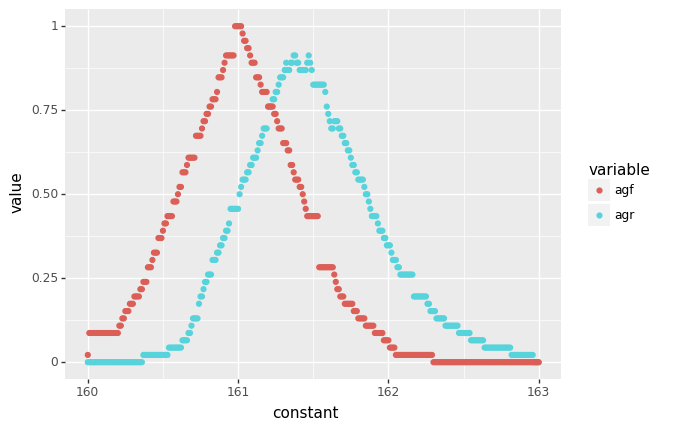

<ggplot: (8794211984898)>

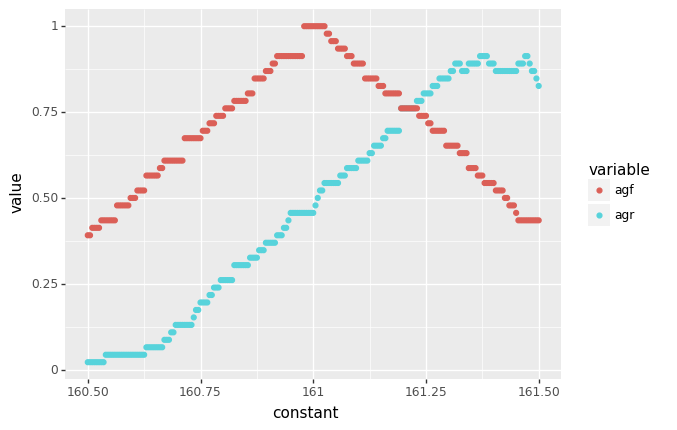

<ggplot: (8794211854886)>

<IPython.core.display.Javascript object>

In [5]:
toprow_df = pd.read_csv("top-row-states.csv")


# toprow_df.assign(revs_per_mile=lambda f: f.cadence * 60 / f.speed)
def round_with_mode(value, decimals, mode):
    with decimal.localcontext() as ctx:
        value_str = str(value)
        d = decimal.Decimal(value_str)
        ctx.rounding = mode
        return float(round(d, decimals))


step = 0.01
recs = []
for rv_mi in np.arange(160, 163 + step / 2, step):
    _df = toprow_df.assign(
        cspeed=lambda f: f.cadence * 60 / rv_mi,
        rspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_HALF_UP)
        ),
        fspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_DOWN)
        ),
        ragreement=lambda f: abs(f.speed - f.rspeed) < 1e-3,
        fagreement=lambda f: abs(f.speed - f.fspeed) < 1e-3,
    )
    rec = dict(constant=rv_mi, agr=_df.ragreement.mean(), agf=_df.fagreement.mean())
    recs.append(rec)

rdf = pd.DataFrame(recs)
(
    p9.ggplot(rdf.melt("constant"), p9.aes("constant", "value", color="variable"))
    + p9.geom_point()
)

step = 0.005
recs = []
for rv_mi in np.arange(160.5, 161.5 + step / 2, step):
    _df = toprow_df.assign(
        cspeed=lambda f: f.cadence * 60 / rv_mi,
        rspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_HALF_UP)
        ),
        fspeed=lambda f: f.cspeed.apply(
            lambda e: round_with_mode(e, 1, decimal.ROUND_DOWN)
        ),
        ragreement=lambda f: abs(f.speed - f.rspeed) < 1e-3,
        fagreement=lambda f: abs(f.speed - f.fspeed) < 1e-3,
    )
    rec = dict(constant=rv_mi, agr=_df.ragreement.mean(), agf=_df.fagreement.mean())
    recs.append(rec)

rdf = pd.DataFrame(recs)
(
    p9.ggplot(rdf.melt("constant"), p9.aes("constant", "value", color="variable"))
    + p9.geom_point()
)

In [6]:
revolutions_per_mile = 161
frames_per_second = 29.97  # ffprobe


# Conversion factors
alpha = 1 / revolutions_per_mile  # for converting revolutions to miles
gamma = 60  # for converting revolutions per second to revolutions per minute

# Initialize the Kalman filter
kf = KalmanFilter(dim_x=2, dim_z=2)

# Initialize the state with the first measurement
kf.x = np.array(
    [
        (rogue_df.dropna().iloc[0]["DISTANCE"]) / alpha,
        (rogue_df.dropna().iloc[0]["CADENCE"] + 0.5) / gamma,
    ]
)

# State transition matrix
kf.F = np.array(
    [
        [
            1,
            1 / frames_per_second,
        ],  # we are assuming the time difference between measurements is 1/30 second
        [0, 1],
    ]
)

# Measurement function
kf.H = np.array([[alpha, 0], [0, gamma]])

# Process noise covariance
df_diff = rogue_df[
    ["DISTANCE", "CADENCE"]
].diff()  # difference between consecutive measurements

# Convert units for DISTANCE (miles to revolutions) and CADENCE (revolutions/minute to revolutions/second)
df_diff["DISTANCE"] *= revolutions_per_mile  # alpha = 161 revolutions/mile
df_diff["CADENCE"] /= 60  # gamma = 1 revolution/second

Q_estimate = df_diff.var().values  # variance of the differences

# Set Q to the estimated values (on diagonal since we assume position and velocity are uncorrelated)
Q = np.diag(Q_estimate)

kf.Q = Q

# Measurement noise covariance
# Calculate variance of the measurements
R_estimate = rogue_df[["DISTANCE", "CADENCE"]].var().values

# Set R to the estimated values (on diagonal since we assume DISTANCE and CADENCE are uncorrelated)
R = np.diag(R_estimate)

kf.R = R * 2

# State covariance matrix
kf.P = np.eye(2)

zs = [
    None if np.isnan(v).any() else [v[0], v[1] + 0.5]
    for v in (e for (_, e) in rogue_df[["DISTANCE", "CADENCE"]].iterrows())
]


class HackedList(list):
    def __init__(self, *args):
        super().__init__(args)

    @property
    def shape(self):
        return [len(self)]


zs_wrapped = HackedList(*zs)


# Apply batch_filter method
mu, cov, _, _ = kf.batch_filter(zs_wrapped)
# mu, cov, _, _ = kf.rts_smoother(mu, cov)


# Store results
results = pd.DataFrame(mu, columns=["Estimated_Position", "Estimated_Velocity"])
results["Seconds"] = rogue_df.index / frames_per_second


results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estimated_Position  8077 non-null   float64
 1   Estimated_Velocity  8077 non-null   float64
 2   Seconds             8077 non-null   float64
dtypes: float64(3)
memory usage: 189.4 KB


<IPython.core.display.Javascript object>

/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 2953 rows containing missing values.


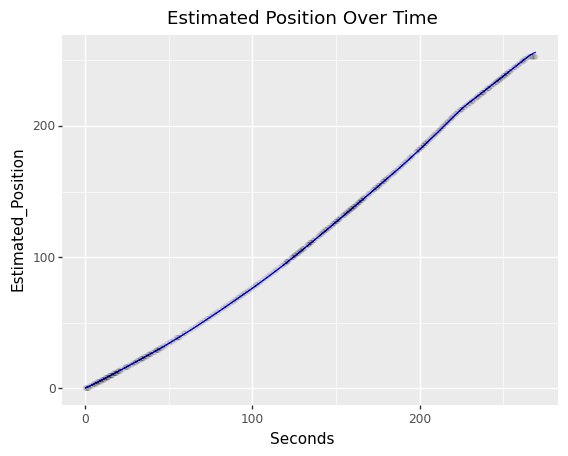

/home/mike/.pyenv/versions/exercise-machina-3.10.11/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 219 rows containing missing values.


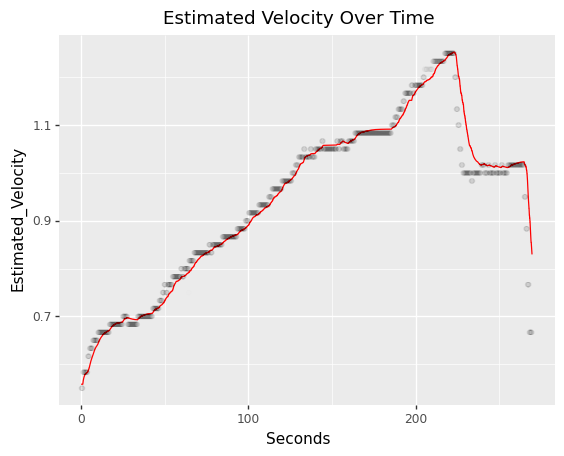

<IPython.core.display.Javascript object>

In [7]:
# Convert results to the correct datatypes
results['Estimated_Position'] = results['Estimated_Position'].astype(float)
results['Estimated_Velocity'] = results['Estimated_Velocity'].astype(float)

# Create position plot
position_plot = (
    p9.ggplot(results) +
    p9.aes(x='Seconds', y='Estimated_Position') +
    p9.geom_line(color='blue') +
    p9.ggtitle('Estimated Position Over Time') +
        p9.geom_point(data=rogue_df.assign(Seconds=lambda f: f.index/frames_per_second),
                  mapping=p9.aes(y="DISTANCE * revolutions_per_mile"),
                  alpha=0.005)
)

# Create velocity plot
velocity_plot = (
    p9.ggplot(results) +
    p9.aes(x='Seconds', y='Estimated_Velocity') +
    p9.geom_line(color='red') +
    p9.ggtitle('Estimated Velocity Over Time') +
    p9.geom_point(data=rogue_df.assign(Seconds=lambda f: f.index/frames_per_second),
                  mapping=p9.aes(y="CADENCE/60"),
                  alpha=0.005)
)

# Display the plots
print(position_plot)
print(velocity_plot)


In [8]:
# Create Kalman filter object
kf_calories = KalmanFilter(dim_x=2, dim_z=1)

# State transition matrix (assuming constant velocity model)
kf_calories.F = np.array([[1.0, 1 / frames_per_second], [0.0, 1.0]])

# Measurement function (we only measure the "position", not the "velocity")
kf_calories.H = np.array([[1.0, 0.0]])

# Initial state
kf_calories.x = np.array([0.0, 0.0]).T  # start at 0 calories, 0 calories/sec

# Initial state covariance
kf_calories.P *= 10.0

# Process noise covariance (modify these values based on your data)
Q_cal_estimate = rogue_df["CALORIES"].diff().var()
kf_calories.Q = (
    Q_discrete_white_noise(dim=2, dt=1 / frames_per_second, var=Q_cal_estimate) * 10
)

# Measurement noise covariance (modify this value based on your data)
R_cal_estimate = rogue_df["CALORIES"].var()
kf_calories.R = np.array([[R_cal_estimate]]) * 10

# Prepare storage for filter output
results_calories = pd.DataFrame(
    columns=["time", "position", "velocity"], index=range(len(rogue_df))
)

# Run the Kalman filter on the data
for i, z in enumerate(rogue_df["CALORIES"].values):
    kf_calories.predict()
    if np.isnan(z):
        # If no measurement is available, only prediction step
        pass
    else:
        # If a measurement is available, use it for update
        kf_calories.update(np.array([z]))
    results_calories.iloc[i] = [
        i / frames_per_second,
        kf_calories.x[0],
        kf_calories.x[1],
    ]  # save estimated position and velocity

results_calories = results_calories.astype(float)

results_calories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      8077 non-null   float64
 1   position  8077 non-null   float64
 2   velocity  8077 non-null   float64
dtypes: float64(3)
memory usage: 189.4 KB


<IPython.core.display.Javascript object>

In [9]:
Q_discrete_white_noise(dim=2, dt=1 / 30, var=Q_cal_estimate)

array([[7.58400030e-10, 4.55040018e-08],
       [4.55040018e-08, 2.73024011e-06]])

<IPython.core.display.Javascript object>

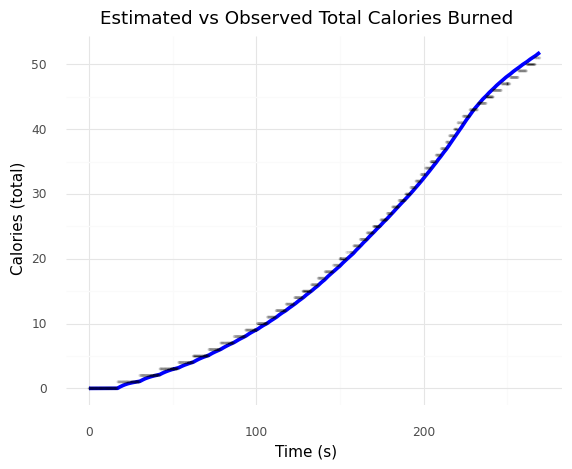

<ggplot: (8794209691291)>

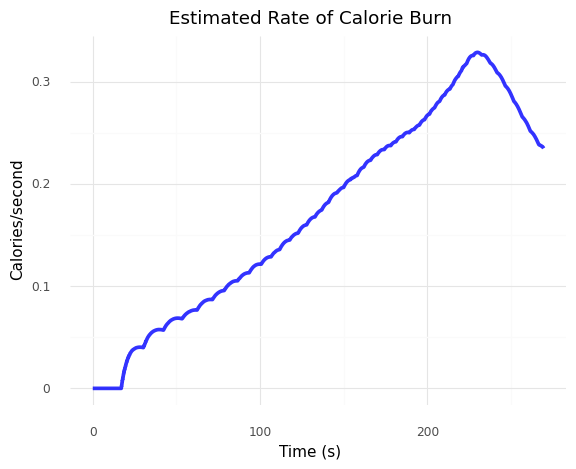

<ggplot: (8794209313519)>

<IPython.core.display.Javascript object>

In [10]:

# Plot estimated "position" (total calories burned) vs observed calories
(
    p9.ggplot() +
    p9.geom_line(data=results_calories, mapping=p9.aes(x='time', y='position'),
                 color='blue', size=1.5,  na_rm=True) +
    p9.geom_point(data=rogue_df.reset_index(), mapping=p9.aes(x='index/29.97', y='CALORIES'), color='black', size=0.5, alpha=0.01, na_rm=True) +
    p9.labs(x='Time (s)', y='Calories (total)', title='Estimated vs Observed Total Calories Burned') +
    p9.theme_minimal()
)

# Plot estimated "velocity" (rate of calorie burn)
(
    p9.ggplot() +
    p9.geom_line(data=results_calories, mapping=p9.aes(x='time', y='velocity'), color='blue', size=1.5, alpha=0.8, na_rm=True) +
    p9.labs(x='Time (s)', y='Calories/second', title='Estimated Rate of Calorie Burn') +
    p9.theme_minimal()
)



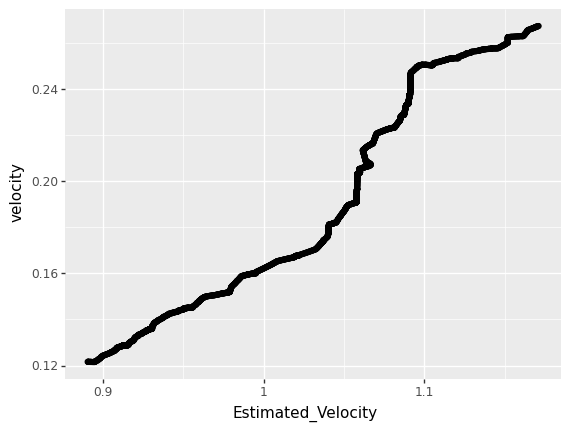

<ggplot: (8794209319405)>

<IPython.core.display.Javascript object>

In [11]:
(
    p9.ggplot(
        results.merge(results_calories, left_on="Seconds", right_on="time").query(
            "time.between(100, 200)"
        ),
        p9.aes(x="Estimated_Velocity", y="velocity"),
    )
    + p9.geom_point()
)